[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/SyntheticRubber.ipynb)

In [3]:
##### При работе в Colab
# !pip install yfinance

In [4]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import numpy as np
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

In [5]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


In [6]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# comment - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [7]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
year = '2022'
month = '05'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)
df = df.drop(columns=['rm'])
df.groupby(df['date']).head()

,date,grade,masa,us,tone
0,2022-05-31,SMR CV,Noon,269.20,Slightly steadier
1,2022-05-31,SMR L,Noon,266.90,Slightly steadier
2,2022-05-31,SMR 5,Noon,172.10,Slightly steadier
3,2022-05-31,SMR GP,Noon,171.40,Slightly steadier
4,2022-05-31,SMR 10,Noon,169.80,Slightly steadier
...,...,...,...,...,...
119,2022-05-05,SMR CV,Noon,259.65,Quietly Steady
120,2022-05-05,SMR L,Noon,257.35,Quietly Steady
121,2022-05-05,SMR 5,Noon,167.75,Quietly Steady
122,2022-05-05,SMR GP,Noon,167.05,Quietly Steady


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками.
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

In [8]:
df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
df_dict

{'USDRUB=X': Date
 2003-12-31     29.402609
 2004-01-31     28.815714
 2004-02-29     28.499000
 2004-03-31     28.524644
 2004-04-30     28.684000
                  ...    
 2022-03-31    111.013403
 2022-04-30     80.666187
 2022-05-31     65.422944
 2022-06-30     60.146091
 2022-07-31     61.442582
 Freq: M, Name: Close, Length: 224, dtype: float64,
 'EURUSD=X': Date
 2003-12-31    1.231372
 2004-01-31    1.260813
 2004-02-29    1.264357
 2004-03-31    1.226723
 2004-04-30    1.199692
                 ...   
 2022-03-31    1.102412
 2022-04-30    1.082745
 2022-05-31    1.057322
 2022-06-30    1.057670
 2022-07-31    1.019509
 Freq: M, Name: Close, Length: 224, dtype: float64,
 'EURRUB=X': Date
 2003-12-31     36.187222
 2004-01-31     36.347455
 2004-02-29     36.083011
 2004-03-31           NaN
 2004-04-30     34.990002
                  ...    
 2022-03-31    132.952291
 2022-04-30     86.109895
 2022-05-31     68.104363
 2022-06-30     60.378959
 2022-07-31     62.204667
 Freq:

In [10]:
main_df = pd.concat(df_dict.values(), axis=1)
main_df.columns = ['USDRUB', 'EURUSD', 'EURRUB']


In [15]:

datedict = main_df.reset_index()['Date'].tolist()
rubber_dict = []
for date in tqdm(datedict):
    rubber_year = date.year
    rubber_month = date.month
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={rubber_month}&year={rubber_year}"
    res = requests.get(url)
    rj = res.json()
    rubber_dict.append(rj)

  0%|          | 0/224 [00:00<?, ?it/s]

In [16]:
rubber_df = pd.DataFrame()
for item in rubber_dict:
    df1 = pd.json_normalize(item)
    df1['date']=pd.to_datetime(df1['date'])
    df1 = df1.drop(columns=['rm', 'masa', 'tone'])
    df1['us'] = df1['us'].replace('',np.nan).astype(float)
    df1 = df1.groupby(['date','grade']).mean()
    prices = df1.reset_index().pivot(index='date', columns='grade', values='us')
    mean_prices = prices.mean()
    mean_prices = mean_prices.rename(prices.reset_index().date.iloc[-1])
    rubber_df = rubber_df.append(mean_prices)
rubber_df.head()

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppData\Local\Temp\ipykernel_12912\1972669208.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rubber_df = rubber_df.append(mean_prices)
C:\Users\Leppy\AppDa

grade,Latex in Bulk,SMR 10,SMR 20,SMR 5,SMR CV,SMR GP,SMR L
2003-12-31,NaN,123.519048,122.988095,125.607143,144.664286,125.378571,134.119048
2004-01-30,NaN,122.311111,121.780556,124.230556,140.150000,124.161111,131.188889
2004-02-27,NaN,126.508824,125.979412,129.144118,147.211765,128.364706,138.414706
2004-03-31,NaN,130.800000,130.260870,133.067391,152.443478,132.652174,148.845652
2004-04-30,NaN,130.423810,129.890476,132.014286,152.450000,132.285714,147.590476


In [17]:
main_df = pd.concat([main_df, rubber_df], axis=1)

In [18]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 310 entries, 2003-12-31 to 2022-07-31
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USDRUB         221 non-null    float64
 1   EURUSD         224 non-null    float64
 2   EURRUB         206 non-null    float64
 3   Latex in Bulk  66 non-null     float64
 4   SMR 10         224 non-null    float64
 5   SMR 20         224 non-null    float64
 6   SMR 5          224 non-null    float64
 7   SMR CV         224 non-null    float64
 8   SMR GP         224 non-null    float64
 9   SMR L          224 non-null    float64
dtypes: float64(10)
memory usage: 26.6 KB


In [19]:
main_df.reset_index(inplace = True)
main_df.head()

,index,USDRUB,EURUSD,EURRUB,Latex in Bulk,SMR 10,SMR 20,SMR 5,SMR CV,SMR GP,SMR L
0,2003-12-31,29.402609,1.231372,36.187222,NaN,123.519048,122.988095,125.607143,144.664286,125.378571,134.119048
1,2004-01-30,NaN,NaN,NaN,NaN,122.311111,121.780556,124.230556,140.150000,124.161111,131.188889
2,2004-01-31,28.815714,1.260813,36.347455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-02-27,NaN,NaN,NaN,NaN,126.508824,125.979412,129.144118,147.211765,128.364706,138.414706
4,2004-02-29,28.499000,1.264357,36.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
main_df = main_df.rename(columns = {'index':'Date'})
main_df['Date'] = main_df['Date'].dt.to_period('M')

In [44]:
main_df = main_df.groupby(['Date'], as_index=False).sum()
main_df.head()

,Date,USDRUB,EURUSD,EURRUB,Latex in Bulk,SMR 10,SMR 20,SMR 5,SMR CV,SMR GP,SMR L
0,2003-12,29.402609,1.231372,36.187222,0.0,123.519048,122.988095,125.607143,144.664286,125.378571,134.119048
1,2004-01,28.815714,1.260813,36.347455,0.0,122.311111,121.780556,124.230556,140.150000,124.161111,131.188889
2,2004-02,28.499000,1.264357,36.083011,0.0,126.508824,125.979412,129.144118,147.211765,128.364706,138.414706
3,2004-03,28.524644,1.226723,0.000000,0.0,130.800000,130.260870,133.067391,152.443478,132.652174,148.845652
4,2004-04,28.684000,1.199692,34.990002,0.0,130.423810,129.890476,132.014286,152.450000,132.285714,147.590476


In [45]:
from pylab import rcParams
rcParams['figure.figsize'] = 25,10

<AxesSubplot:xlabel='Date'>

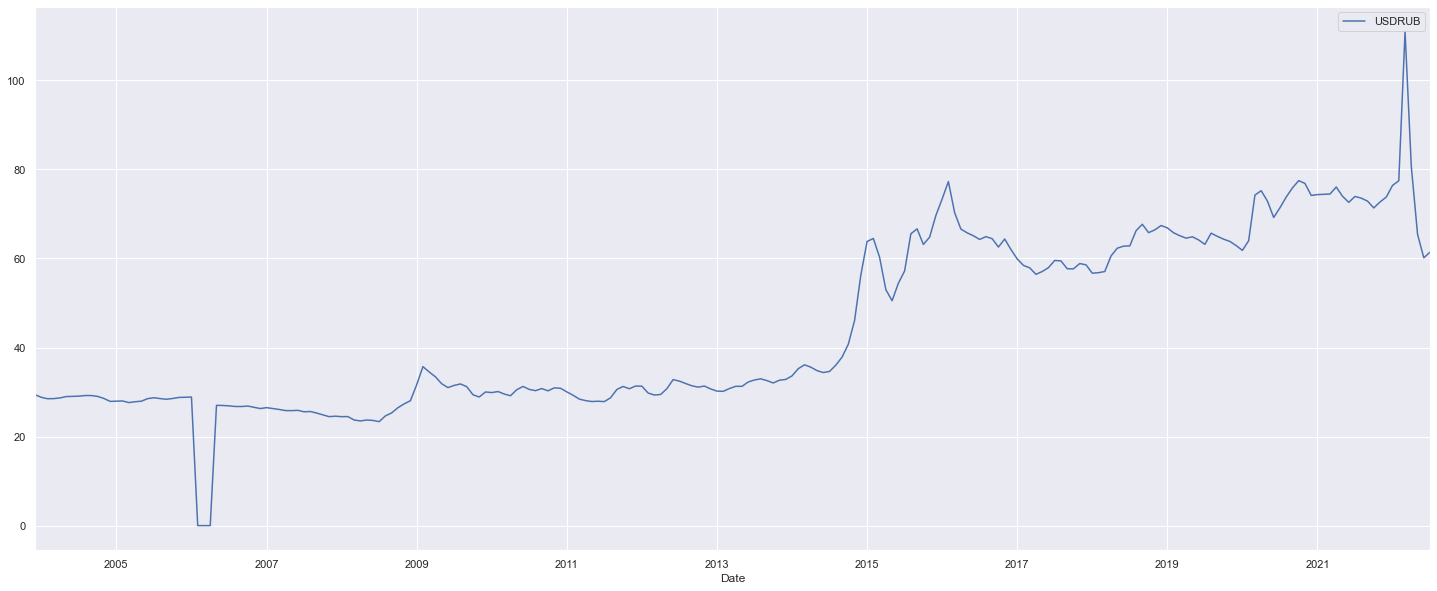

In [46]:
main_df.plot(x='Date', y='USDRUB')

In [52]:
rub_prices_df = main_df.iloc[:,4:].mul(main_df['USDRUB'], axis=0).round(2)
rub_prices_df['Date'] = main_df['Date']
rub_prices_df.head()

,Latex in Bulk,SMR 10,SMR 20,SMR 5,SMR CV,SMR GP,SMR L,Date
0,0.0,3631.78,3616.17,3693.18,4253.51,3686.46,3943.45,2003-12
1,0.0,3524.48,3509.19,3579.79,4038.52,3577.79,3780.30,2004-01
2,0.0,3605.37,3590.29,3680.48,4195.39,3658.27,3944.68,2004-02
3,0.0,3731.02,3715.64,3795.70,4348.40,3783.86,4245.77,2004-03
4,0.0,3741.08,3725.78,3786.70,4372.88,3794.48,4233.49,2004-04


<AxesSubplot:xlabel='Date'>

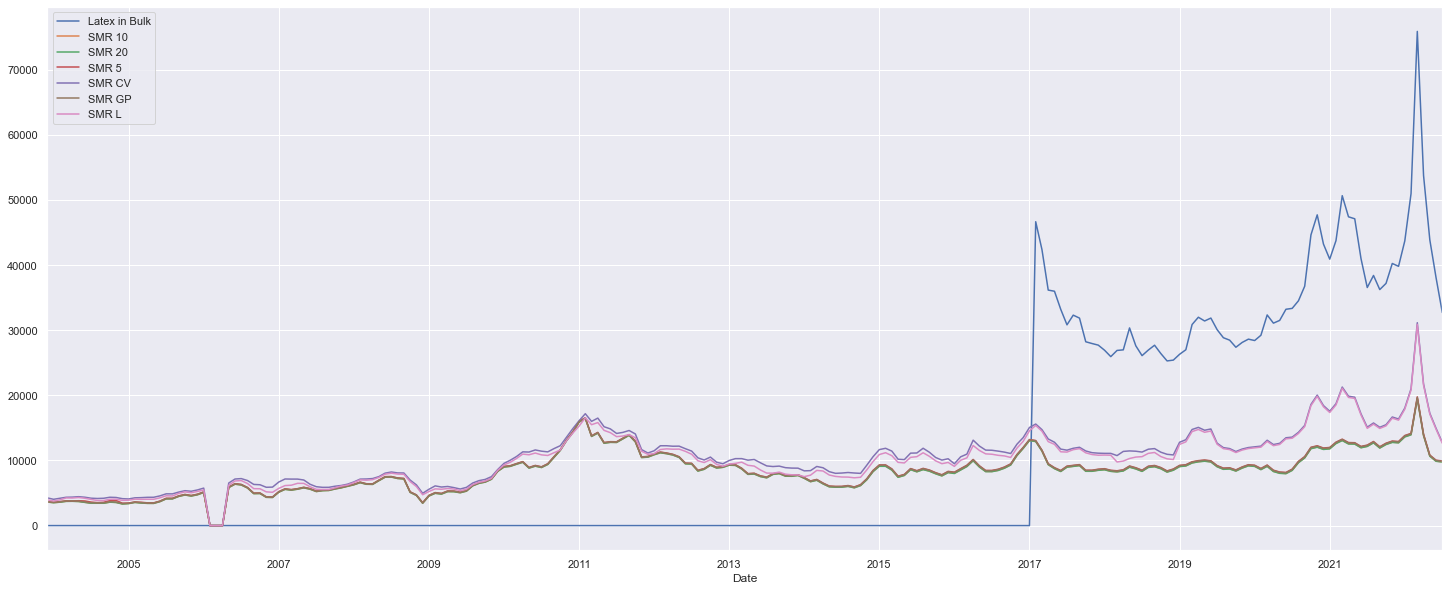

In [54]:
rub_prices_df.plot(x='Date')

In [55]:
euro_prices_df = main_df.iloc[:,4:].div(main_df['EURUSD'], axis=0).round(2)
euro_prices_df['Date'] = main_df['Date']
euro_prices_df.head()

,Latex in Bulk,SMR 10,SMR 20,SMR 5,SMR CV,SMR GP,SMR L,Date
0,0.0,100.31,99.88,102.01,117.48,101.82,108.92,2003-12
1,0.0,97.01,96.59,98.53,111.16,98.48,104.05,2004-01
2,0.0,100.06,99.64,102.14,116.43,101.53,109.47,2004-02
3,0.0,106.63,106.19,108.47,124.27,108.14,121.34,2004-03
4,0.0,108.71,108.27,110.04,127.07,110.27,123.02,2004-04


<AxesSubplot:xlabel='Date'>

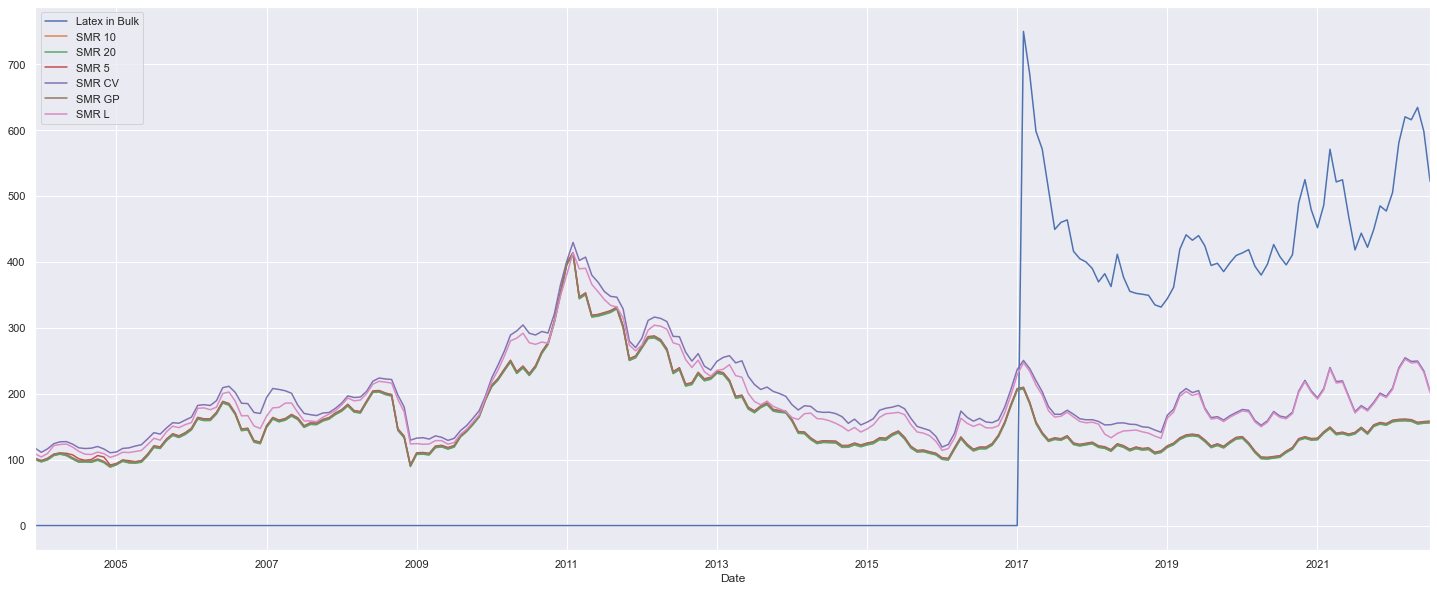

In [56]:
euro_prices_df.plot(x='Date')

# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [4]:
# 

# Задание 3. Back to Russia

К вам пришел новый клиент из России, он готов регулярно закупать синтетический каучук. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a> или из любого другого источника.


In [5]:
# 

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [6]:
# 

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [7]:
# import yourpackage

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage